In [38]:
pip install fastdtw


     ---------------------------------------- 0.0/133.4 kB ? eta -:--:--
     --- ------------------------------------ 10.2/133.4 kB ? eta -:--:--
     ------------------- ----------------- 71.7/133.4 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 133.4/133.4 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3585 sha256=45ccb07d2965973a7dcfe97e2fa4cd9b16ef077be99731ca9ee90ad0b2a65263
  Stored in directory: c:\users\alper\appdata\local\pip\cache\wheels\5c\8a\f6\fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
Note: you may need to restart the kernel to use updated packages.


In [125]:
import pandas as pd
from colorama import Style, Fore
import numpy as np
from fastdtw import fastdtw
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [101]:
train = pd.read_csv('train.csv')
train_calendar = pd.read_csv('train_calendar.csv')
test = pd.read_csv('test.csv')
test_calendar = pd.read_csv('test_calendar.csv')
sub  = pd.read_csv('solution_example.csv')

In [102]:
test.columns

Index(['warehouse', 'date', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')

In [129]:
train.columns

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday', 'shutdown',
       'mini_shutdown', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'id',
       'kmeans_cluster'],
      dtype='object')

In [103]:
train.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


In [104]:
test.head()

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,2024-03-17,NaN,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,2024-03-18,NaN,0,0,0,0,Prague_1_2024-03-18
3,Prague_1,2024-03-19,NaN,0,0,0,0,Prague_1_2024-03-19
4,Prague_1,2024-03-20,NaN,0,0,0,0,Prague_1_2024-03-20


In [105]:
initial_features = list(test.columns)
target = 'orders'
print(f'Initial features: {Style.BRIGHT}{Fore.GREEN} {initial_features} {Style.RESET_ALL}')
print(f'target: {Style.BRIGHT}{Fore.BLUE}{target} {Style.RESET_ALL}')

Initial features:  ['warehouse', 'date', 'holiday_name', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'] 
target: orders 


In [106]:
print(f'{Style.BRIGHT}{Fore.YELLOW} SHAPE')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> train: {Fore.GREEN} {train.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> train_calendar: {Fore.GREEN} {train.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> test:  {Fore.GREEN} {test.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> test_calendar:  {Fore.GREEN} {test_calendar.shape}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} NULL VALUES')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.isnull().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.isnull().any().any()}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} DUPLICATES')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.duplicated().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.duplicated().any().any()}')

 SHAPE
 -> train:  (7340, 18)
 -> train_calendar:  (7340, 18)
 -> test:   (397, 8)
 -> test_calendar:   (1869, 7)


 NULL VALUES
 -> Train:  True
 -> Test:   True


 DUPLICATES
 -> Train:  False
 -> Test:   False


In [107]:
%%time
dc = train.copy()
list_wh = train.warehouse.unique()
dim_matrix =  dc['warehouse'].drop_duplicates().shape[0]
distance_matrix = np.zeros((dim_matrix,dim_matrix))
for i,v1 in enumerate(list_wh):
    w1 = dc[dc.warehouse==v1]['orders'].values
    for j,v2 in enumerate(list_wh):
        w2 = dc[dc.warehouse==v2]['orders'].values
    
        distance, path = fastdtw(w1,w2)
        distance_matrix[i][j] = distance

CPU times: total: 453 ms
Wall time: 3.92 s


In [108]:
# Now we try to find the number of ideal clusters, using the Silhouette score.
# The Silhouette Score can be used to determine the optimal number of clusters in a clustering analysis, 
# as it provides a measure of how compact and well separated the clusters are. 
# The higher the average Silhouette Score for a given number of clusters, the better the separation between the clusters.

In [109]:
%%time
max_clusters = 6
clusters = np.arange(2,max_clusters+1)
silhouttes = []
for c in clusters:
    model = AgglomerativeClustering(metric='precomputed', n_clusters=c, linkage='complete').fit(distance_matrix)    
    s = silhouette_score(distance_matrix, model.fit_predict(distance_matrix))
    silhouttes.append(s)

CPU times: total: 0 ns
Wall time: 12.4 ms


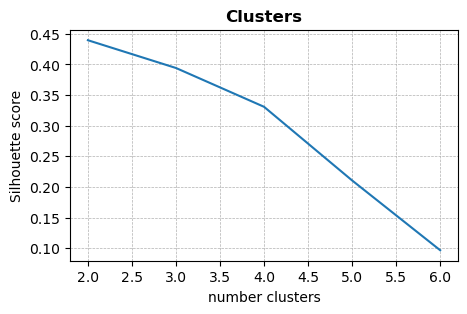

In [110]:
plt.figure(figsize=(5,3))
plt.plot(clusters,silhouttes)
plt.grid(True,lw=0.5,ls='--')
plt.ylabel('Silhouette score')
plt.xlabel('number clusters')
plt.title('Clusters',fontweight='bold');

In [111]:
model = AgglomerativeClustering(metric='precomputed',
                                n_clusters=2,
                                linkage='complete').fit(distance_matrix)
clusters = model.labels_
c = dict(zip(list_wh,clusters))
dc['clusters'] = dc['warehouse'].copy()
dc['clusters'] = dc['clusters'].map(c)
display(dc[['warehouse', 'clusters']].drop_duplicates().groupby('clusters').count().reset_index())
display(pd.DataFrame(list(c.items()), columns=['warehouse', 'cluster']).style.background_gradient(axis=0))

del dc
gc.collect()

,clusters,warehouse
0,0,5
1,1,2


,warehouse,cluster
0,Prague_1,1
1,Brno_1,1
2,Prague_2,0
3,Prague_3,0
4,Munich_1,0
5,Frankfurt_1,0
6,Budapest_1,0


3753

In [120]:
# Önce train veri seti için KMeans kullanımı
X_train = train[['orders']].values  # orders sütununu alarak X_train'i oluşturuyoruz

max_clusters = 6
clusters = np.arange(2, max_clusters + 1)
silhouettes_train = []

for c in clusters:
    kmeans = KMeans(n_clusters=c, random_state=42, n_init=10)  # n_init parametresini belirtiyoruz
    labels_train = kmeans.fit_predict(X_train)
    silhouette_avg_train = silhouette_score(X_train, labels_train)
    silhouettes_train.append(silhouette_avg_train)

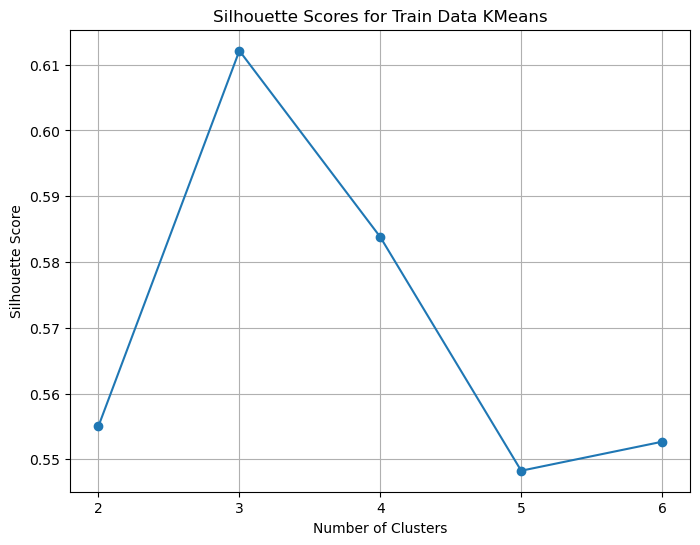

In [122]:
plt.figure(figsize=(8, 6))
plt.plot(clusters, silhouettes_train, marker='o')
plt.title('Silhouette Scores for Train Data KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(clusters)
plt.grid(True)
plt.show()

In [112]:
# As we can see, from the results Prague_1 and Brno_1 belong to the same cluster, 
# and the others to another. We can train 2 models, one for each cluster.

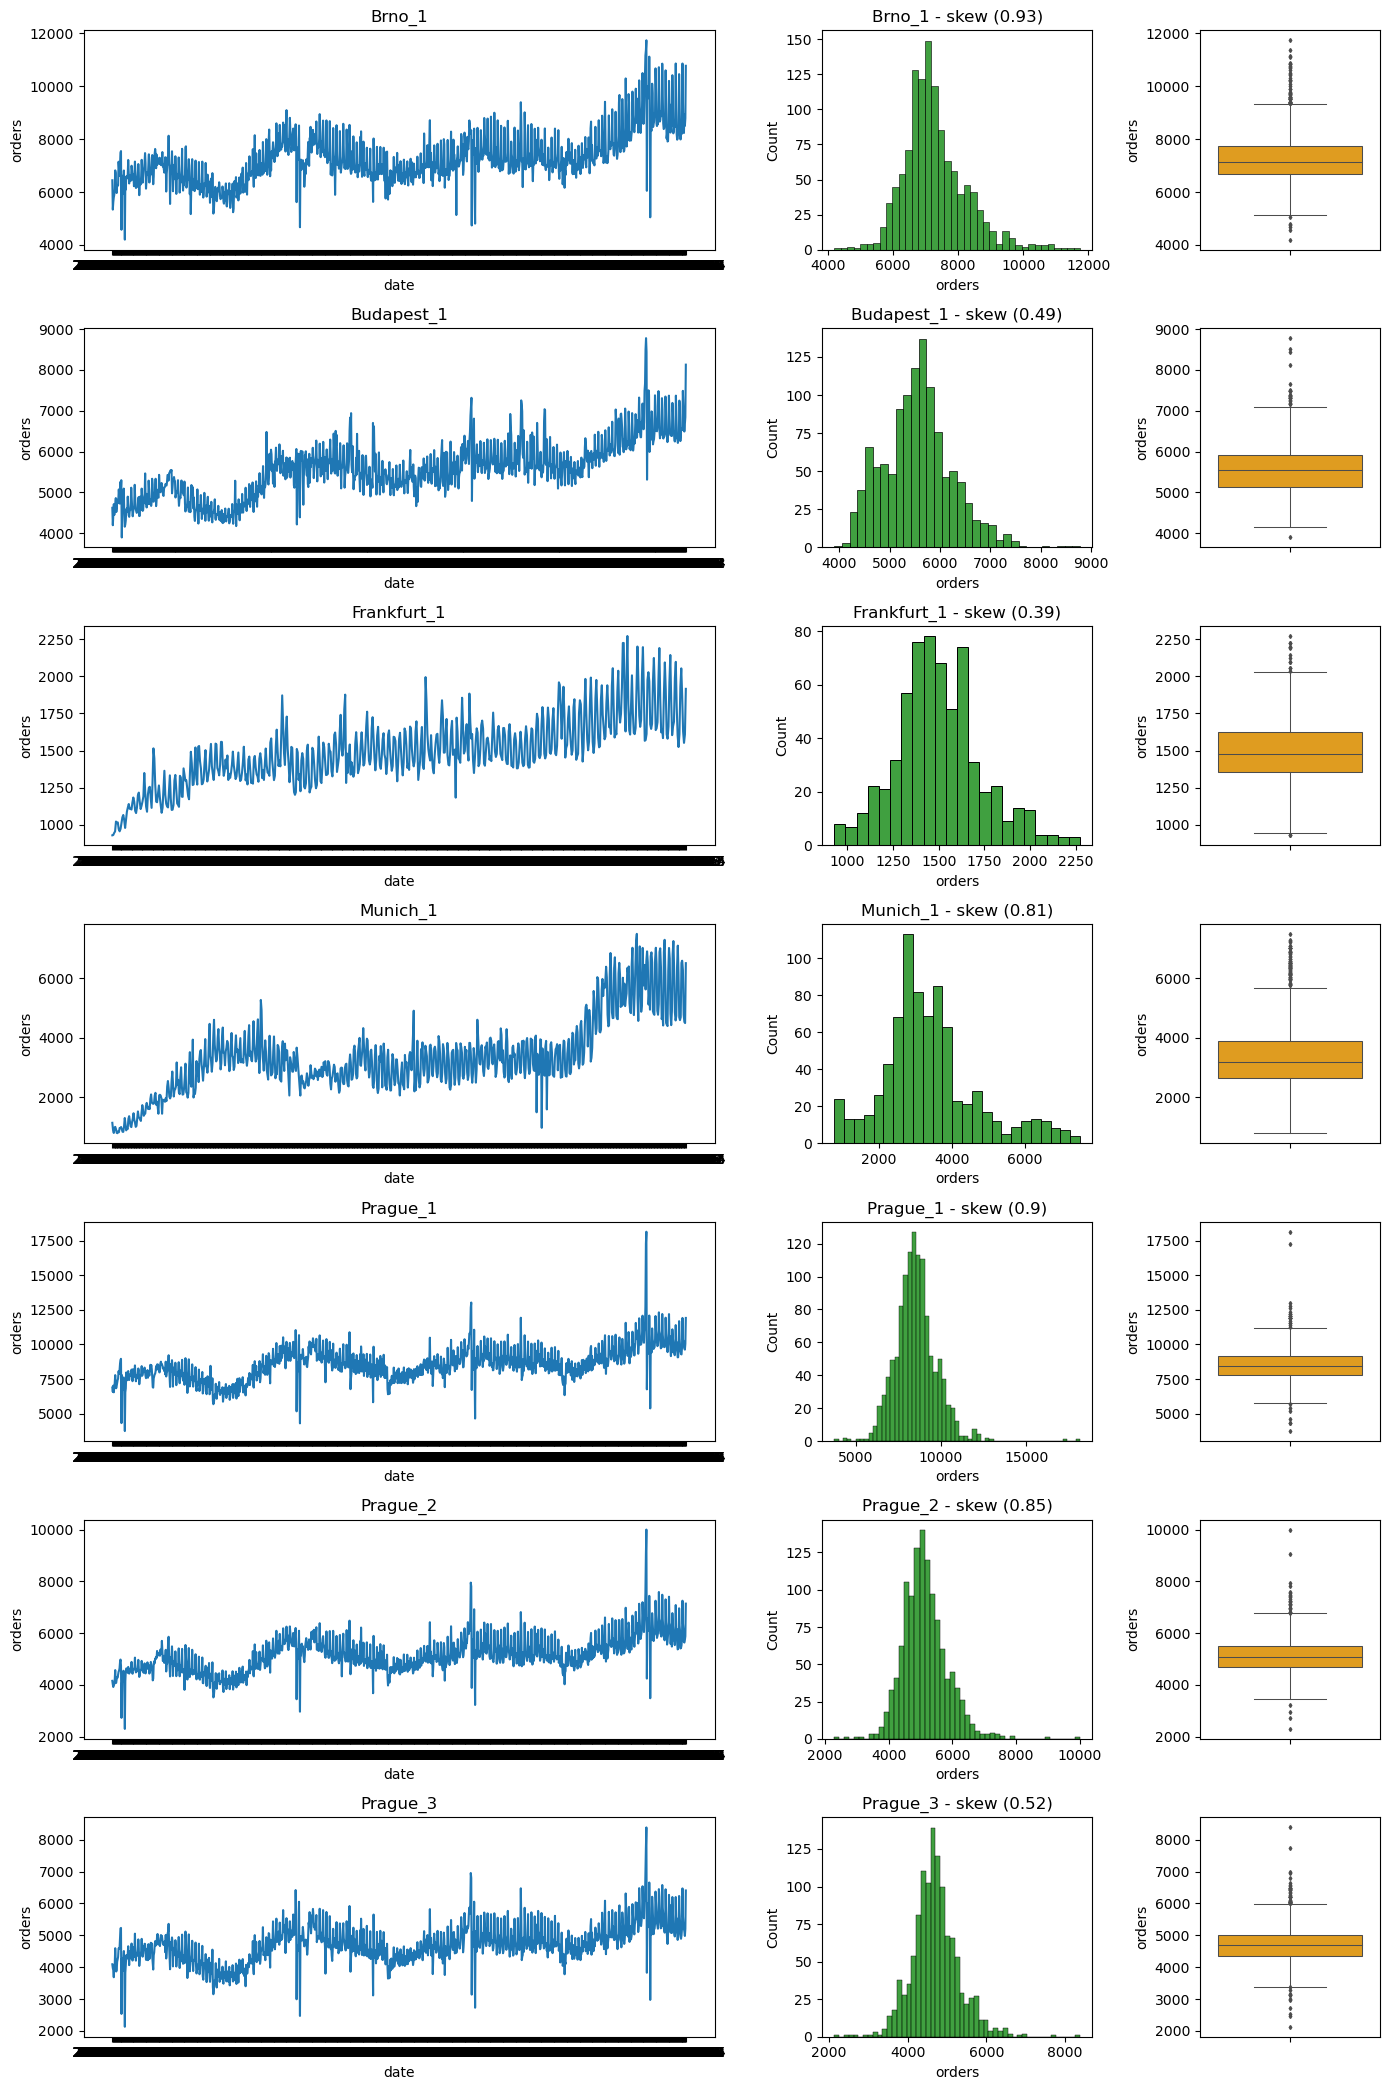

In [113]:
fig, axes = plt.subplots(7,3, figsize=(14,7*3), gridspec_kw={'width_ratios':[0.70, 0.30, 0.20 ]})

for i,(ind, c) in enumerate(train.groupby('warehouse')):   
    ax = axes[i,0]
    sns.lineplot(data=c,x=c.date,y='orders',ax=ax)
    ax.set_title(f'{ind}')
    
    ax = axes[i,1]
    sns.histplot(data=c,x='orders',ax=ax,color='green')               
    ax.set_title(f'{ind} - skew ({c.orders.skew().round(2)})')
    
    ax = axes[i,2]
    sns.boxplot(data=c,y='orders',ax=ax,color='orange', linewidth=.75, fliersize=2.01, width=0.80)               
    
plt.tight_layout()    